# Notebook for Extensions 1 and 2

This notebook includes replicating all extension 1 and 2 figures found in the report, gives more details about some assumptions made, and intermediate findings. Concretely:
1. Examples how to load the saved saliency models.
2. Evaluation of the classifier, brief analysis of MIMIC-III.
3. Use the classifier to correctly predict mortality of patients. Use the result to visualize examples of which temporal features are deemed important classifier as found by ExtremalMask and DynaMask methods (Figures 1a, 1b in our report).
4. Compute perturbations NN(x) and using them compute alternative saliency metric.
5. Reproduce Figure 5 from the original paper, compute same figure using new saliency metric. (Figures 2a, 2b in our report)
6. Visualize original data, perturbed data, and predicted mask. Do the same with new saliency metric as well. (Figures X in the report's Appendix)
7. Plot the components of perturbation of a univariate time series signal for in-depth understanding of the model. (Figures X in the report's Appendix)
8. Similar visualizations for synthetic HMM (Figures X in the report's Appendix) and ARMA datasets.

The exact extensions in our report are formulated as follows:

**Extension 1**. Using ExtremalMask, we propose a new metric for data saliency. Using this, we re-evaluate the information and entropy (defined in Section 3.4.1) on HMM

**Extension 2**. We visually analyze the saliency map using the new metric learned by ExtremalMask and its predecessor DynaMask on the MIMIC-III dataset. Furthermore, we compare the saliency of the top 5 most important features of the MIMIC-III dataset using these two saliency metrics.

**Note!** The data comes in the shape of (batch size, time series length, no. features). This means that if we want to visualize the first batch of data, we do `data[0].T`. Transpose is important to put features as rows to show time series data horizontally!

## MIMIC-III

All of these experiments have been done for the MIMIC-III *mortality* dataset (classification task), NOT the *blood pressure* part (regression task).

In [1]:
import numpy as np
import torch as th

# The default seed set in the tint experiments, and subsequently used by us
SEED = 42
# For this fold we have all methods saved, for some (like retain and deep lift)
# we forgot to save the fold 0
FOLD = 1

MIMIC_CKPT_DIR = "experiments/checkpoints/mimic_copy/"
# PICKLE_DIR = "experiments/pickles/"
PICKLE_DIR = MIMIC_CKPT_DIR
CLS_DIR = "experiments/checkpoints/mimic3_classifier/"

### Load different explanation models

We load the attributions, explainer class, and mask net (when applicable) all of which have been saved on Snellius to facilitate reproduction and save computational resources.

In [2]:
from pytorch_lightning import seed_everything
from tint.datasets import Mimic3

deterministic = True
device = "cpu"
dataset_name = "mimic3"
model_name = "extremal_mask"
lambda_1 = 1.0
lambda_2 = 1.0
preservation_mode = True

if deterministic:
    seed_everything(seed=SEED, workers=True)

# Get accelerator and device
accelerator = device.split(":")[0]
device_id = 1
if len(device.split(":")) > 1:
    device_id = [int(device.split(":")[1])]

# Load data
mimic3 = Mimic3(n_folds=5, fold=FOLD, seed=SEED)
x_train_mimic = mimic3.preprocess(split="train")["x"].to(device)
x_test_mimic = mimic3.preprocess(split="test")["x"].to(device)
y_test_mimic = mimic3.preprocess(split="test")["y"].to(device)

/home/paulius/projects/fact/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


In [3]:
import torch.nn as nn
from experiments.mimic3.mortality.classifier import MimicClassifierNet
from pytorch_lightning import Trainer
from tint.attr import ExtremalMask
from tint.attr.models import ExtremalMaskNet
from tint.models import MLP, RNN
from tint.utils.model_loading import get_model

# Create classifier
mimic3_cls = MimicClassifierNet(
    feature_size=31,
    n_state=2,
    hidden_size=200,
    regres=True,
    loss="cross_entropy",
    lr=0.0001,
    l2=1e-3,
)

# Train classifier
cls_trainer = Trainer(
    max_epochs=100,
    accelerator=accelerator,
    devices=device_id,
    deterministic=deterministic,
    logger=False,
)
mimic3_cls = get_model(
    cls_trainer,
    mimic3_cls,
    "classifier",
    dataset_name,
    SEED,
    FOLD,
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    datamodule=None,
    checkpoint_dir="experiments/checkpoints/mimic3_classifier/",
)

# Switch to eval
mimic3_cls.eval()

# Set model to device
mimic3_cls.to(device)

trainer = Trainer(
    max_epochs=500,
    accelerator=accelerator,
    devices=device_id,
    log_every_n_steps=2,
    deterministic=deterministic,
    logger=False,
)
extremal_mask_mask_net_mimic = ExtremalMaskNet(
    forward_func=mimic3_cls,
    preservation_mode=preservation_mode,
    model=nn.Sequential(
        RNN(
            input_size=x_test_mimic.shape[-1],
            rnn="gru",
            hidden_size=x_test_mimic.shape[-1],
            bidirectional=True,
        ),
        MLP([2 * x_test_mimic.shape[-1], x_test_mimic.shape[-1]]),
    ),
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    loss="cross_entropy",
    optim="adam",
    lr=0.01,
)
explainer = ExtremalMask(dataset_name, mimic3_cls, SEED, FOLD)
_attr = explainer.attribute(
    x_test_mimic,
    trainer=trainer,
    mask_net=extremal_mask_mask_net_mimic,
    batch_size=100,
)
extremal_mask_attr_mimic = _attr.to(device)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trying to load experiments/checkpoints/mimic3_classifier//mimic3_classifier_42_1.ckpt
classifier has loaded the saved weights on mimic3 dataset with fold = 1, if applicable, lambda 1 = 1.0 and lambda 2 = 1.0.
extremal_mask has loaded the saved weights on mimic3 dataset with fold = 1, if applicable, lambda 1 = 1.0 and lambda 2 = 1.0.


In [4]:
import numpy as np
from tint.attr import DynaMask
from tint.attr.models import MaskNet

trainer = Trainer(
    max_epochs=1000,
    accelerator=accelerator,
    devices=device_id,
    log_every_n_steps=2,
    deterministic=deterministic,
    logger=False,
)
mask = MaskNet(
    forward_func=mimic3_cls,
    perturbation="fade_moving_average",
    keep_ratio=list(np.arange(0.1, 0.7, 0.1)),
    deletion_mode=True,
    size_reg_factor_init=0.1,
    size_reg_factor_dilation=10000,
    time_reg_factor=0.0,
    loss="cross_entropy",
)
explainer = DynaMask(dataset_name, mimic3_cls, SEED, FOLD)
dyna_mask_attr_mimic, dyna_mask_mask_net_mimic = explainer.attribute(
    x_test_mimic,
    additional_forward_args=(True,),
    trainer=trainer,
    mask_net=mask,
    batch_size=100,
    return_best_ratio=False,
)
dyna_mask_attr_mimic = dyna_mask_attr_mimic.to(device)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


dyna_mask has loaded the saved weights on mimic3 dataset with fold = 1, if applicable, lambda 1 = None and lambda 2 = None.
Predicting DataLoader 0: 100%|██████████| 46/46 [00:17<00:00,  2.56it/s]


In [5]:
from tint.utils.perturbations import compute_alternative, compute_perturbations

# Batch size for dyna is also 100
(
    extremal_mimic_batch,
    extremal_perturbation_mimic,
    extremal_mask_attr_mimic_batch,
    extremal_x1_mimic,
    extremal_x2_mimic,
) = compute_perturbations(
    data=x_test_mimic,
    mask_net=extremal_mask_mask_net_mimic,
    perturb_net=extremal_mask_mask_net_mimic.net.model,
    batch_idx=0,
)
extremal_alternative_mimic = compute_alternative(
    batch=extremal_mimic_batch,
    mask=extremal_mask_attr_mimic_batch,
    perturbation=extremal_perturbation_mimic,
)

# Batch size for dyna is also 100
(
    dyna_mimic_batch,
    dyna_perturbation_mimic,
    dyna_mask_attr_mimic_batch,
    dyna_x1_mimic,
    dyna_x2_mimic,
) = compute_perturbations(
    data=x_test_mimic,
    mask_net=dyna_mask_mask_net_mimic,
    perturb_net=None,
    batch_idx=0,
)
dyna_alternative_mimic = compute_alternative(
    batch=dyna_mimic_batch,
    mask=dyna_mask_attr_mimic_batch,
    perturbation=dyna_perturbation_mimic,
)

The warning here is expected because the listed methods do not have a learned mask model.

### Load MIMIC-III dataset

This is needed for visualizing multiple results, computing perturbations and new saliencies.

In [6]:
# from pytorch_lightning import seed_everything
# from tint.datasets import Mimic3

# # Make sure all seeds are set before loading data for reproducible results
# seed_everything(seed=SEED, workers=True)
# mimic3 = Mimic3(n_folds=5, fold=FOLD, seed=SEED)

# # Need to preprocess train before accessing test
# x_train = mimic3.preprocess(split="train")["x"]
# inputs_mimic = mimic3.preprocess(split="test")["x"]
# # Access the labels - whether the patient died (1) or not (0)
# y_test = mimic3.preprocess(split="test")["y"]

### Load and evaluate MIMIC-III classifier (only possible with access to MIMIC-III dataset)

In [8]:
cls_trainer.test(mimic3_cls, dataloaders=mimic3)
print()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-02-03 00:35:41.214236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 00:35:41.214284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 00:35:41.216138: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 00:35:41.226024: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 00:35:43.471039: W tensorflow/compiler/tf2

Testing DataLoader 0: 100%|██████████| 144/144 [00:02<00:00, 49.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.913223147392273
       test_auroc             0.7833251953125
        test_loss           0.25653332471847534
        test_pre            0.5903614163398743
        test_rec            0.11835748702287674
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



In [9]:
outcomes_train = mimic3.preprocess(split="train")["y"]
alive_train, dead_train = outcomes_train.unique(return_counts=True)[1]
total_train = len(outcomes_train)
print(f"Total patients in the training set: {total_train}")
print(
    f"Alive patients: {alive_train} ({alive_train/total_train * 100 :.2f}%), dead: {dead_train} ({dead_train/total_train * 100:.2f}%)"
)

Total patients in the training set: 18390
Alive patients: 16514 (89.80%), dead: 1876 (10.20%)


As we can see, the dataset is very imbalanced. We observe that the classifier has achieved a high accuracy (91.3%), but it is not that good if we note that 89.80% of the data points in the training dataset have negative labels. We should bear this result in mind when looking at our subsequent analysis.

### Figure out at which indices the classifier predicted a positive class

In [10]:
# Batch size = 32, that's why 144 predictions / epochs
predictions = trainer.predict(mimic3_cls, dataloaders=mimic3.test_dataloader())

# Convert classification network's logits to concrete predictions
intermediate = np.array(predictions[0])
for i in range(1, len(predictions)):
    intermediate = np.append(intermediate, predictions[i], axis=0)

predictions = th.argmax(th.tensor(intermediate), dim=1)

Predicting DataLoader 0: 100%|██████████| 144/144 [00:02<00:00, 55.41it/s]


In [11]:
# Take only the dead patients
dead_indices = th.where(y_test == 1)[0]
# For which patients did the classifier correctly predict deaths?
dead_indices[th.where(y_test[dead_indices] == predictions[dead_indices])[0]]

tensor([   4,   64,  223,  316,  345,  399,  673,  687,  728,  747,  764,  928,
         954, 1030, 1073, 1171, 1235, 1317, 1430, 1527, 1680, 1718, 1778, 1801,
        1966, 1971, 1991, 2110, 2242, 2254, 2257, 2381, 2383, 2408, 2430, 2702,
        2717, 2777, 2838, 3045, 3086, 3095, 3113, 3136, 3173, 3262, 3422, 3449,
        3462, 3575, 3585, 3589, 3604, 3661, 3968, 3972, 3983, 4006, 4025, 4061,
        4155, 4256, 4281, 4420, 4483, 4517, 4581])

### Compute perturbations using the trained networks of ExtremalMask and DynaMask

In [12]:
from tint.utils.perturbations import compute_alternative, compute_perturbations

# Batch size for extremal was 100, which has idx = 0 if we want to visualize NEG_ID = 33 or POS_ID = 64
(
    extremal_mimic_batch,
    extremal_perturbation_mimic,
    extremal_mask_attr_mimic_batch,
    extremal_x1_mimic,
    extremal_x2_mimic,
) = compute_perturbations(
    data=inputs_mimic,
    mask_net=extremal_mask_net,
    perturb_net=extremal_mask_net.net.model,
    batch_idx=0,
)

extremal_alternative_mimic = compute_alternative(
    batch=extremal_mimic_batch,
    mask=extremal_mask_attr_mimic_batch,
    perturbation=extremal_perturbation_mimic,
)

# Batch size for dyna is also 100
(
    dyna_mimic_batch,
    dyna_perturbation_mimic,
    dyna_mask_attr_mimic_batch,
    dyna_x1_mimic,
    dyna_x2_mimic,
) = compute_perturbations(
    data=inputs_mimic,
    mask_net=dyna_mask_mask_net_mimic,
    perturb_net=None,
    batch_idx=0,
)
dyna_alternative_mimic = compute_alternative(
    batch=dyna_mimic_batch,
    mask=dyna_mask_attr_mimic_batch,
    perturbation=dyna_perturbation_mimic,
)

### Plot mask and alternative saliency for ExtremalMask and DynaMask methods for positive class (Figure 1)

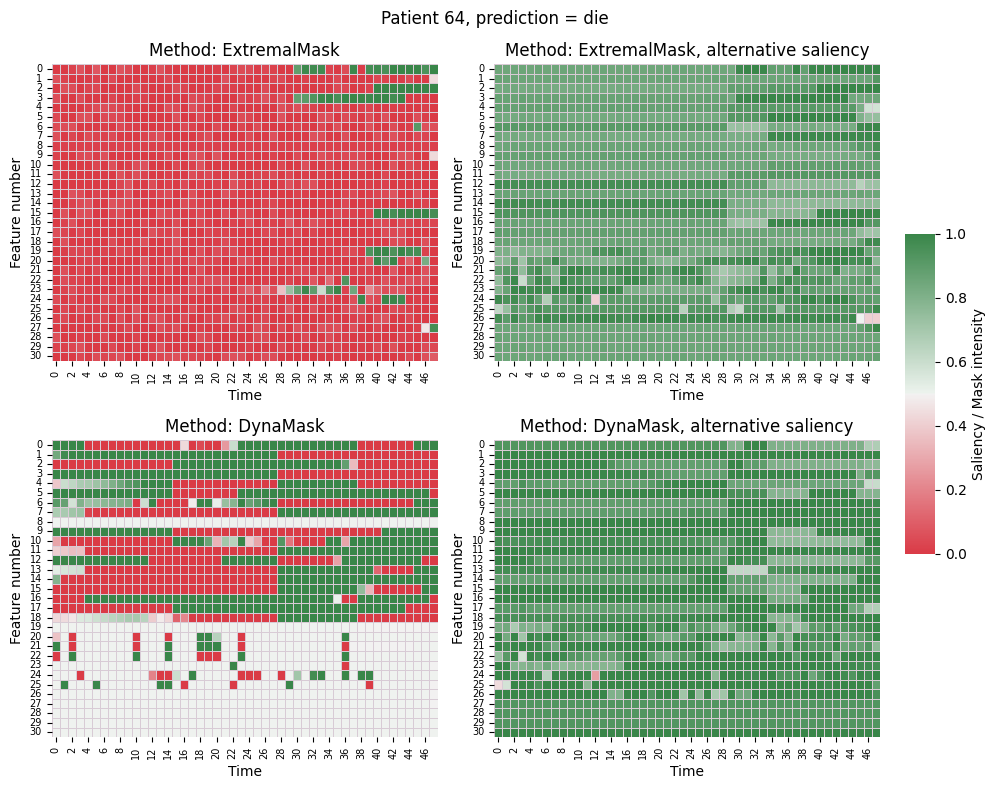

In [13]:
from tint.utils.plotting import plot_heatmap

POS_ID = 64  # This is an example of the indices found above
saliencies = {
    "ExtremalMask": extremal_mask_attr_mimic[POS_ID].T,
    "ExtremalMask, alternative saliency": extremal_alternative_mimic[POS_ID].T,
    "DynaMask": dyna_mask_attr_mimic[POS_ID].T,
    "DynaMask, alternative saliency": dyna_alternative_mimic[POS_ID].T,
}
plot_heatmap(saliencies, title=f"Patient {POS_ID}, prediction = die")

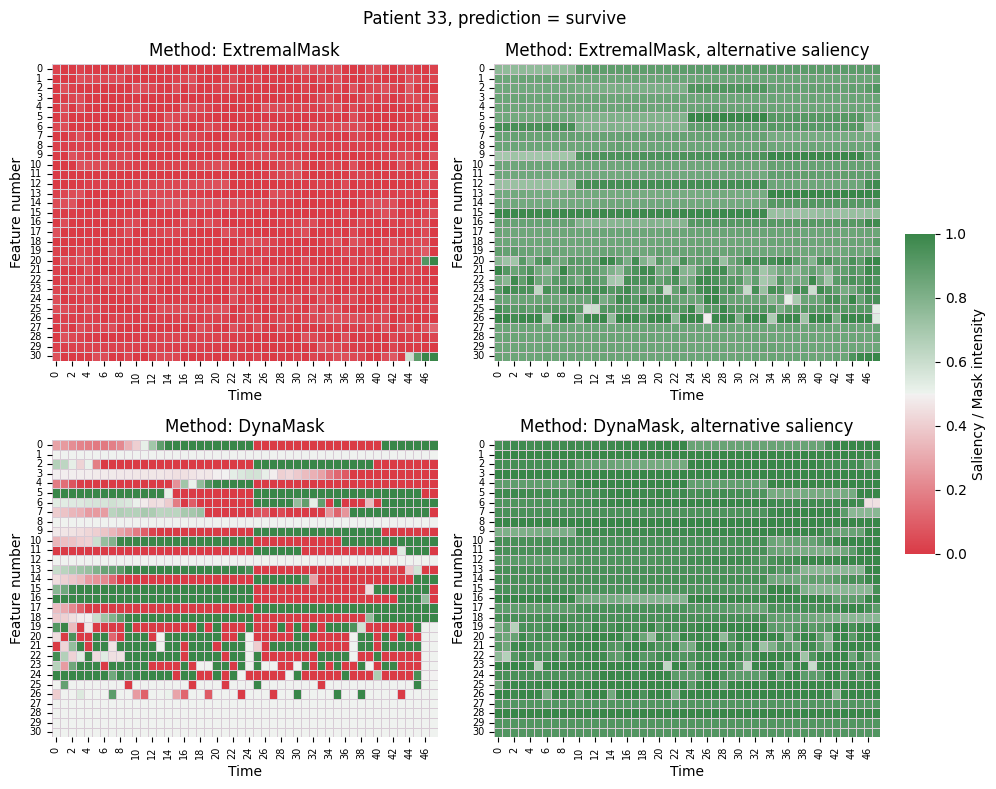

In [14]:
NEG_ID = 33
saliencies = {
    "ExtremalMask": extremal_mask_attr_mimic[NEG_ID].T,
    "ExtremalMask, alternative saliency": extremal_alternative_mimic[NEG_ID].T,
    "DynaMask": dyna_mask_attr_mimic[NEG_ID].T,
    "DynaMask, alternative saliency": dyna_alternative_mimic[NEG_ID].T,
}
plot_heatmap(saliencies, title=f"Patient {NEG_ID}, prediction = survive")

### Compare many explainer methods on a positive sample (Figure X in the appendix)

In [15]:
from tint.utils.model_loading import load_explainer

aug_occlusion_attr_mimic, _, _ = load_explainer(
    dataset_name="mimic3",
    method="augmented_occlusion",
    seed=SEED,
    fold=FOLD,
    pickle_dir=PICKLE_DIR,
)
deep_lift_attr_mimic, _, _ = load_explainer(
    dataset_name="mimic3",
    method="deep_lift",
    seed=SEED,
    fold=FOLD,
    pickle_dir=PICKLE_DIR,
)
integrated_gradients_attr_mimic, _, _ = load_explainer(
    dataset_name="mimic3",
    method="integrated_gradients",
    seed=SEED,
    fold=FOLD,
    pickle_dir=PICKLE_DIR,
)
retain_attr_mimic, _, _ = load_explainer(
    dataset_name="mimic3", method="retain", seed=SEED, fold=FOLD, pickle_dir=PICKLE_DIR
)

Could not find and load experiments/checkpoints/mimic_copy/mimic3_augmented_occlusion_mask_42_1
Could not find and load experiments/checkpoints/mimic_copy/mimic3_deep_lift_mask_42_1
Could not find and load experiments/checkpoints/mimic_copy/mimic3_integrated_gradients_mask_42_1
Could not find and load experiments/checkpoints/mimic_copy/mimic3_retain_mask_42_1


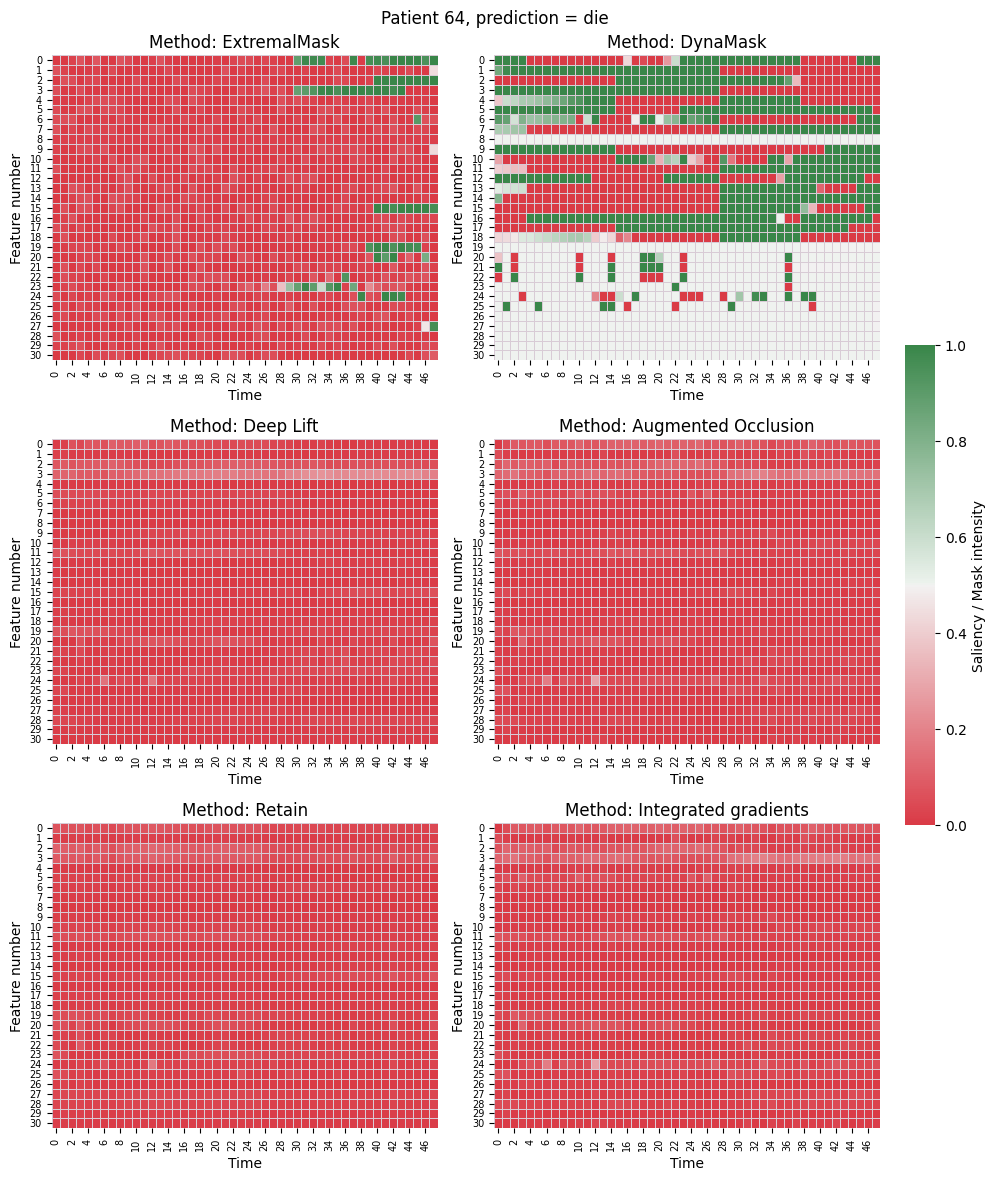

In [16]:
saliencies = {
    "ExtremalMask": extremal_mask_attr_mimic[POS_ID].T,
    "DynaMask": dyna_mask_attr_mimic[POS_ID].T,
    "Deep Lift": deep_lift_attr_mimic[POS_ID].T,
    "Augmented Occlusion": aug_occlusion_attr_mimic[POS_ID].T,
    "Retain": retain_attr_mimic[POS_ID].T,
    "Integrated gradients": aug_occlusion_attr_mimic[POS_ID].T,
}
plot_heatmap(saliencies, title=f"Patient {POS_ID}, prediction = die")

### Compare many explainer methods on a negative sample (Figure X in the appendix)

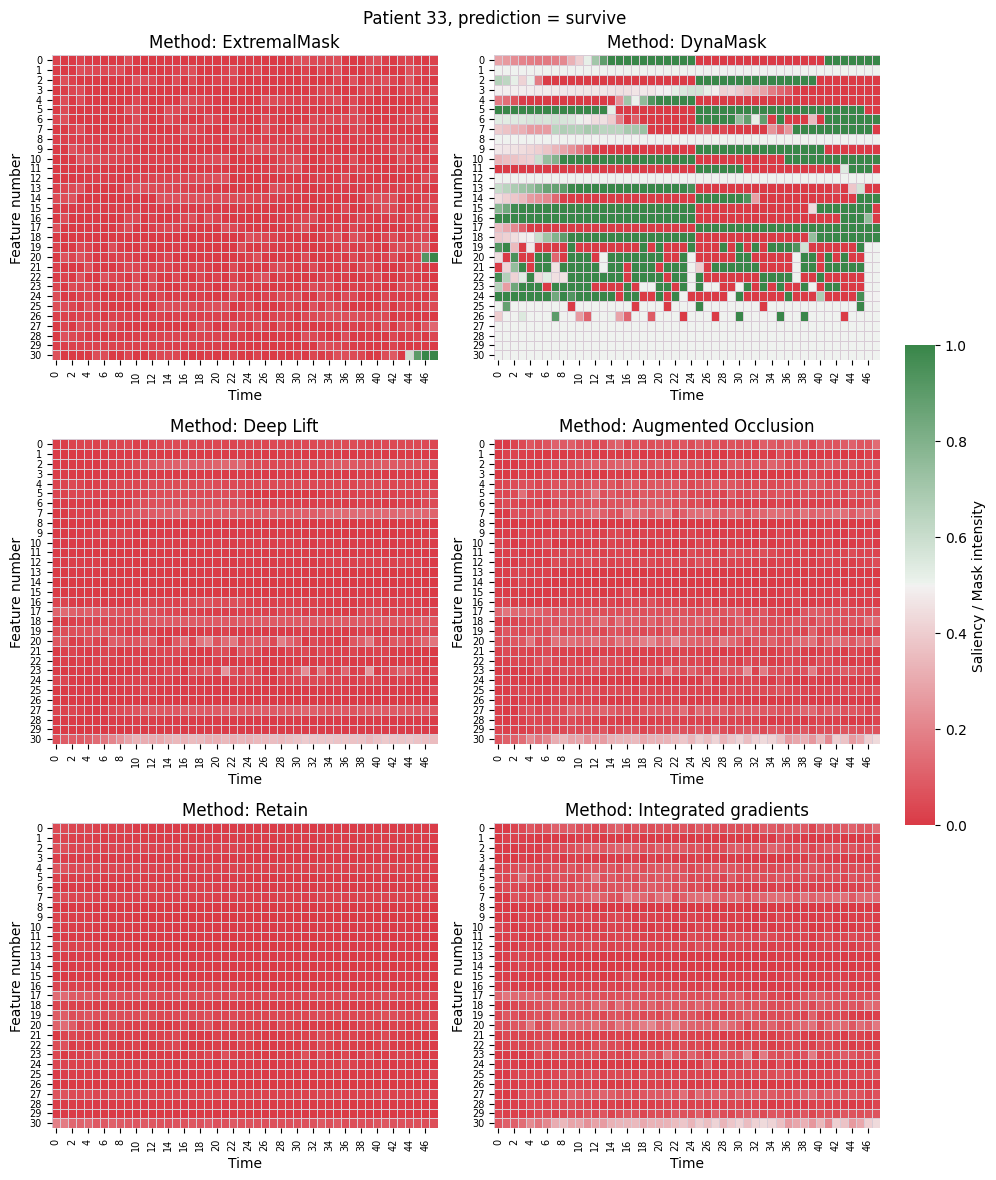

In [17]:
saliencies = {
    "ExtremalMask": extremal_mask_attr_mimic[NEG_ID].T,
    "DynaMask": dyna_mask_attr_mimic[NEG_ID].T,
    "Deep Lift": deep_lift_attr_mimic[NEG_ID].T,
    "Augmented Occlusion": aug_occlusion_attr_mimic[NEG_ID].T,
    "Retain": retain_attr_mimic[NEG_ID].T,
    "Integrated gradients": aug_occlusion_attr_mimic[NEG_ID].T,
}
plot_heatmap(saliencies, title=f"Patient {NEG_ID}, prediction = survive")

### Detailed visualization of saliency predictions (Figure 2a)

In [ ]:
from tint.datasets.mimic3 import lab_IDs, vital_IDs

# Load all feature names for plotting later
other_features = ["Gender", "Age", "Ethnicity", "First ICU stay"]
feature_names = np.array(lab_IDs + vital_IDs + other_features)

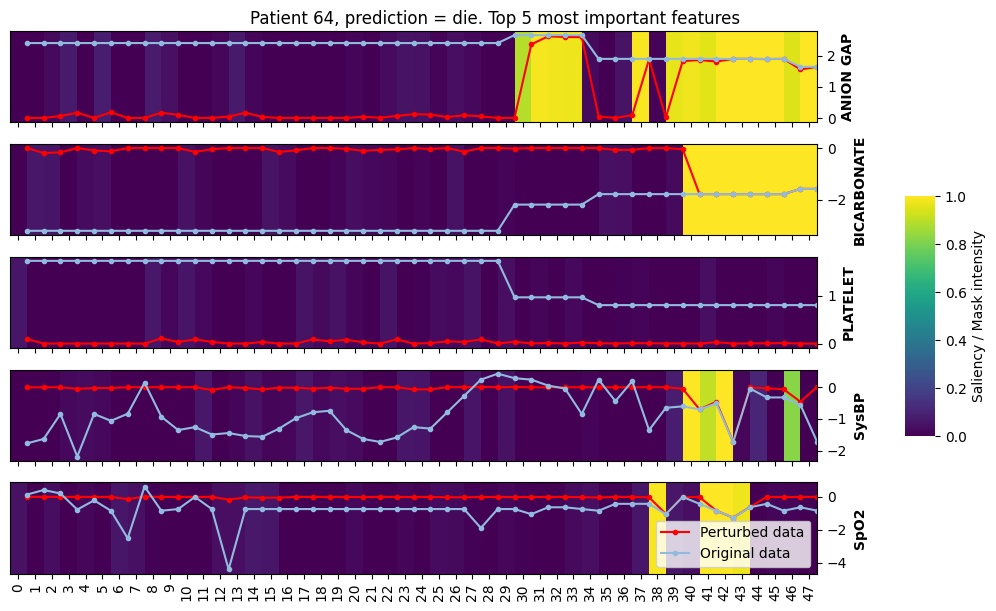

In [18]:
from tint.utils.plotting import plot_saliency

# Take the top 5 important features from the mean attribution plot below
imp_feat_idx = np.array([0, 2, 11, 20, 24])
plot_saliency(
    ts_data=extremal_mimic_batch[POS_ID].T[imp_feat_idx],
    saliency_list=extremal_mask_attr_mimic[POS_ID].T[imp_feat_idx],
    perturbed=extremal_x1_mimic[POS_ID].T[imp_feat_idx],
    suptitle=f"Patient {POS_ID}, prediction = die. Top 5 most important features",
    feature_names=np.array(feature_names)[imp_feat_idx],
)

### Investigate ANION GAP feature at a closer look (Figure X in the Appendix)

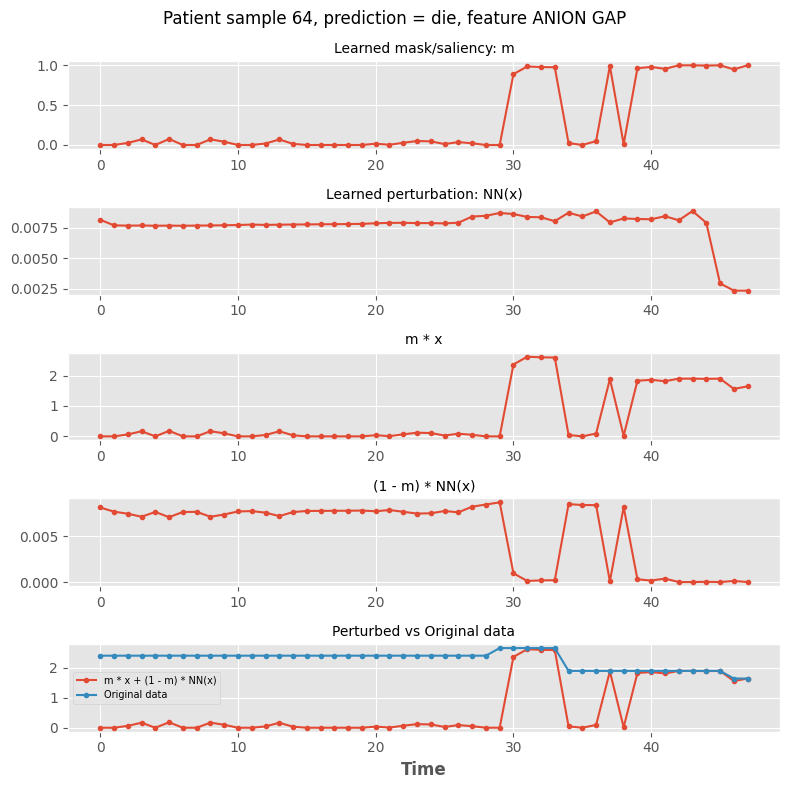

In [19]:
from tint.utils.plotting import plot_components

feat_no = 0  # ANION GAP index
plot_components(
    orig=extremal_mimic_batch[POS_ID].T[feat_no],
    perturbed=extremal_x1_mimic[POS_ID].T[feat_no],
    mask=extremal_mask_attr_mimic[POS_ID].T[feat_no],
    perturbation=extremal_perturbation_mimic[POS_ID].T[feat_no],
    suptitle=f"Patient sample {POS_ID}, prediction = die, feature {feature_names[feat_no]}",
    figsize=(8, 8),
)

### Plotting alternative saliency (Figure 2b)

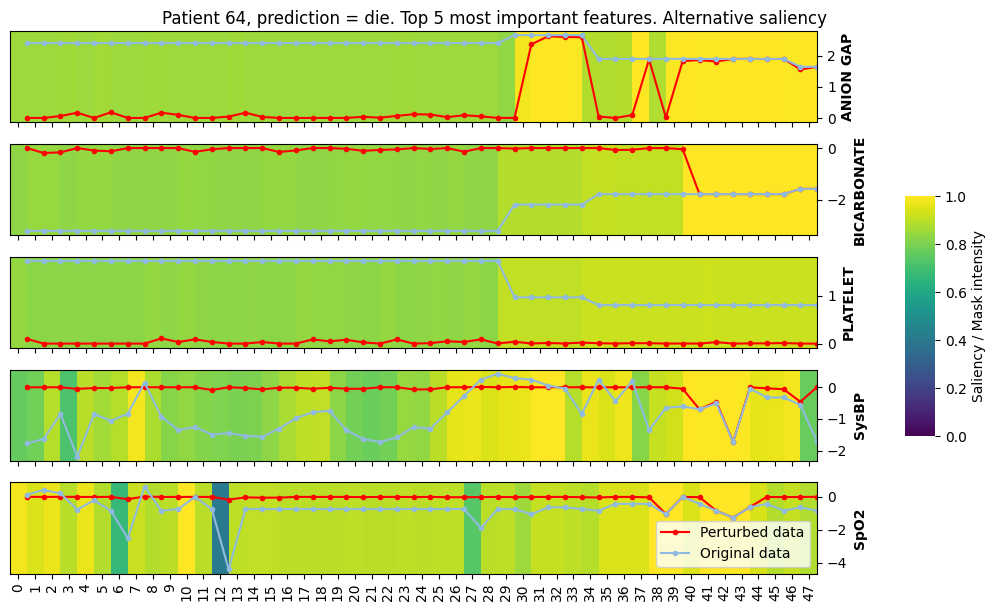

In [20]:
plot_saliency(
    ts_data=extremal_mimic_batch[POS_ID].T[imp_feat_idx],
    saliency_list=extremal_alternative_mimic[POS_ID].T[imp_feat_idx],
    perturbed=extremal_x1_mimic[POS_ID].T[imp_feat_idx],
    suptitle=f"Patient {POS_ID}, prediction = die. Top 5 most important features. Alternative saliency",
    feature_names=np.array(feature_names)[imp_feat_idx],
)

###  Plotting feature importances for identifying deaths in patients (Figure 3 in our paper)

Reproducing Figure 5 from the original paper

In [23]:
# Filter data to postive (dead) patients
dead_indices = th.where(y_test == 1)[0]
dead_attr = extremal_mask_attr_mimic[dead_indices]
dead_attr.shape

torch.Size([414, 48, 31])

414 positive, or dead, patients.

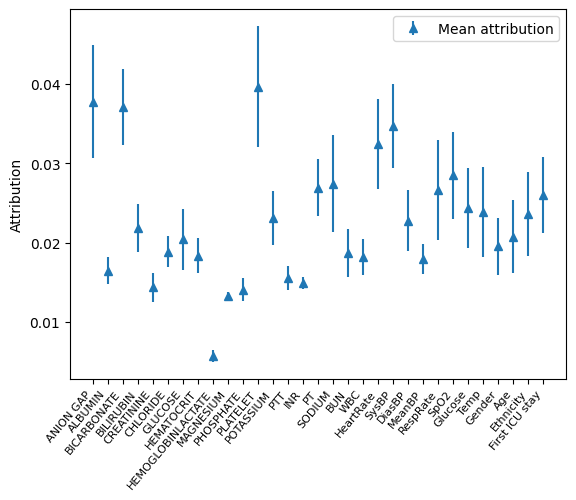

In [24]:
from tint.utils.plotting import plot_mean_attributions

plot_mean_attributions(attr=dead_attr, xtick_labels=feature_names)

In [25]:
mimic_batch, perturbation_mimic, mask_mimic, x1_mimic, x2_mimic = compute_perturbations(
    data=inputs_mimic,
    mask_net=extremal_mask_mask_net_mimic,
    perturb_net=extremal_mask_mask_net_mimic.net.model,
    batch_idx=None,  # Set to None to compute perturbations for the whole dataset
)
alternative_mimic = compute_alternative(
    batch=mimic_batch, mask=mask_mimic, perturbation=perturbation_mimic
)
# Cut alternative to the dead/positive cases
dead_alternative = alternative_mimic[dead_indices]

NameError: name 'extremal_mask_mask_net_mimic' is not defined

In [ ]:
plot_mean_attributions(dead_alternative, xtick_labels=feature_names)

The most important features for identifying deaths using the original saliency are: PLATELET, ANION GAP, BICARBONATE, SysBP, HeartRate. 

The most important features for identifying deaths using the alternative saliency are: WBC, Temp, SpO2, RespRate, DiasBP.

## HMM

In [18]:
SEED = 42
FOLD = 0
HMM_PICKLE_DIR = "experiments/pickles/hmm_copy/"

In [19]:
from tint.utils.model_loading import load_explainer

dyna_mask_attr_hmm, dyna_mask_explainer_hmm, dyna_mask_mask_net_hmm = load_explainer(
    dataset_name="hmm",
    method="dyna_mask",
    seed=SEED,
    fold=FOLD,
    pickle_dir=HMM_PICKLE_DIR,
)
(
    extremal_mask_attr_hmm,
    extremal_mask_explainer_hmm,
    extremal_mask_mask_net_hmm,
) = load_explainer(
    dataset_name="hmm",
    method="extremal_mask",
    seed=SEED,
    fold=FOLD,
    pickle_dir=HMM_PICKLE_DIR,
)

In [ ]:
# TODO: use mask net instead of the cached mask

### Method 1 (shorter)

In [ ]:
# Load HMM data
from pytorch_lightning import seed_everything
from tint.datasets import HMM

# Load only the test data because the classifier was trained on train part
# but the mask net and explainer was trained on the test part to explain the
# classifier's decision
# hmm.download(split="train")
# x_train = hmm.preprocess(split="train")["x"]

# Make sure to seed before data generation to return numpy and other libraries to their original state
# in order to generate the same data with the same seed as the process for training the models
seed_everything(seed=SEED, workers=True)

FOLD = 0

hmm = HMM(n_folds=5, fold=FOLD, seed=SEED)
hmm.download(split="test")
inputs_hmm = hmm.preprocess(split="test")["x"]
y_hmm = hmm.preprocess(split="test")["y"]
true_saliency_hmm = hmm.true_saliency(split="test")
print("batch size, time series length, no. features", inputs_hmm.size())

In [ ]:
from tint.utils.perturbations import compute_perturbations

(
    extremal_batch_hmm,
    extremal_perturbation_hmm,
    extremal_mask_hmm,
    extremal_x1_hmm,
    extremal_x2_hmm,
) = compute_perturbations(
    data=inputs_hmm,
    mask_net=extremal_mask_mask_net_hmm,
    perturb_net=extremal_mask_mask_net_hmm.net.model,
    batch_idx=0,
)

In [ ]:
from tint.utils.plotting import plot_components

feat_no = 1
POS_ID = 2
plot_components(
    orig=extremal_batch_hmm[POS_ID].T[feat_no],
    perturbed=extremal_x1_hmm[POS_ID].T[feat_no],
    mask=extremal_mask_hmm[POS_ID].T[feat_no],
    perturbation=extremal_perturbation_hmm[POS_ID].T[feat_no],
    suptitle=f"HMM sample {POS_ID}, feature {feat_no}",
    figsize=(8, 8),
)

In [ ]:
from tint.metrics.white_box import aup, aur, entropy, information, rmse

print(f"AUP: {aup(extremal_mask_attr_hmm2.cpu(), true_saliency_hmm):.4}")
print(f"AUR: {aur(extremal_mask_attr_hmm2.cpu(), true_saliency_hmm):.4}")
# print(f"RMSE: {rmse(extremal_mask_attr_hmm, true_saliency_hmm):.4}")
print(f"Information: {information(extremal_mask_attr_hmm2, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(extremal_mask_attr_hmm2, true_saliency_hmm):.4}")

# 0.9167, 0.7638, 2.954e05, 7.595e03 (snellius)
# 0.9164, 0.7644, 2.961e+05, 7.52e+03 (locally trained on cpu)

In [ ]:
from tint.metrics.white_box import aup, aur, entropy, information, rmse

print(f"AUP: {aup(extremal_mask_attr_hmm.cpu(), true_saliency_hmm.cpu()):.4}")
print(f"AUR: {aur(extremal_mask_attr_hmm, true_saliency_hmm):.4}")
# print(f"RMSE: {rmse(extremal_mask_attr_hmm, true_saliency_hmm):.4}")
print(f"Information: {information(extremal_mask_attr_hmm, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(extremal_mask_attr_hmm, true_saliency_hmm):.4}")

# 0.9167, 0.7638, 2.954e05, 7.595e03 (snellius)
# 0.9164, 0.7644, 2.961e+05, 7.52e+03 (locally trained on cpu)

In [ ]:
from tint.metrics.white_box import aup, aur, entropy, information, rmse

print(f"AUP: {aup(dyna_mask_attr_hmm, true_saliency_hmm):.4}")
print(f"AUR: {aur(dyna_mask_attr_hmm, true_saliency_hmm):.4}")
# print(f"RMSE: {rmse(dyna_mask_attr_hmm, true_saliency_hmm):.4}")
print(f"Information: {information(dyna_mask_attr_hmm, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(dyna_mask_attr_hmm, true_saliency_hmm):.4}")

# 0.3731, 0.7712, 1.049e05, 2.528e04

In [ ]:
Seed, Fold, Explainer, Lambda_1, Lambda_2, AUP, AUR, Information, Entropy, AUROC, AUPRC
42, 2, deep_lift, 1.0, 1.0, 0.9336, 0.3154, 2.851e04, 2.958e04, 0.9243, 0.889
42, 3, deep_lift, 1.0, 1.0, 0.9299, 0.333, 3.032e04, 3.018e04, 0.9261, 0.8917
42, 1, deep_lift, 1.0, 1.0, 0.9324, 0.3224, 2.915e04, 2.995e04, 0.9268, 0.8918
42, 0, deep_lift, 1.0, 1.0, 0.9335, 0.3327, 3.032e04, 3.014e04, 0.9291, 0.8965
42, 2, dyna_mask, 1.0, 1.0, 0.3759, 0.7728, 1.051e05, 2.536e04, 0.6197, 0.4182
42, 3, dyna_mask, 1.0, 1.0, 0.375, 0.7685, 1.049e05, 2.529e04, 0.6167, 0.4189
42, 1, dyna_mask, 1.0, 1.0, 0.375, 0.7726, 1.054e05, 2.532e04, 0.6157, 0.4155
42, 3, extremal_mask, 1.0, 1.0, 0.901, 0.7609, 2.96e05, 7.285e03, 0.9081, 0.8801
42, 0, extremal_mask, 1.0, 1.0, 0.9167, 0.7638, 2.954e05, 7.595e03, 0.913, 0.893
42, 2, extremal_mask, 1.0, 1.0, 0.9115, 0.7546, 2.872e05, 7.641e03, 0.9085, 0.8848
42, 1, extremal_mask, 1.0, 1.0, 0.8967, 0.764, 2.978e05, 7.332e03, 0.9077, 0.8783
42, 4, deep_lift, 1.0, 1.0, 0.9273, 0.3356, 3.054e04, 3.032e04, 0.9256, 0.889
42, 4, dyna_mask, 1.0, 1.0, 0.3811, 0.7716, 1.057e05, 2.52e04, 0.6297, 0.4282
42, 4, extremal_mask, 1.0, 1.0, 0.892, 0.7557, 2.898e05, 7.674e03, 0.9045, 0.8727
42, 0, fit, 1.0, 1.0, 0.5186, 0.622, 8.364e04, 3.361e04, 0.846, 0.5958
42, 1, fit, 1.0, 1.0, 0.4856, 0.5718, 7.389e04, 3.364e04, 0.7973, 0.5411
42, 2, fit, 1.0, 1.0, 0.4651, 0.4618, 6.412e04, 3.012e04, 0.7419, 0.4856
42, 3, fit, 1.0, 1.0, 0.4738, 0.6052, 7.954e04, 3.413e04, 0.8127, 0.5395
42, 3, gradient_shap, 1.0, 1.0, 0.8819, 0.288, 2.601e04, 2.793e04, 0.8472, 0.7704
42, 0, gradient_shap, 1.0, 1.0, 0.8888, 0.287, 2.589e04, 2.789e04, 0.851, 0.7806
42, 2, gradient_shap, 1.0, 1.0, 0.8898, 0.2735, 2.46e04, 2.734e04, 0.8484, 0.7721
42, 1, gradient_shap, 1.0, 1.0, 0.8882, 0.2786, 2.5e04, 2.767e04, 0.8492, 0.775
42, 1, integrated_gradients, 1.0, 1.0, 0.9322, 0.3174, 2.858e04, 2.983e04, 0.926, 0.8899
42, 2, integrated_gradients, 1.0, 1.0, 0.9331, 0.3109, 2.803e04, 2.947e04, 0.9233, 0.8868
42, 0, integrated_gradients, 1.0, 1.0, 0.9331, 0.327, 2.964e04, 3.003e04, 0.9278, 0.8941
42, 3, integrated_gradients, 1.0, 1.0, 0.9295, 0.328, 2.974e04, 3.008e04, 0.925, 0.8895
42, 0, augmented_occlusion, 1.0, 1.0, 0.8724, 0.3526, 3.051e04, 3.4e04, 0.9345, 0.8624
42, 3, augmented_occlusion, 1.0, 1.0, 0.8573, 0.3544, 3.071e04, 3.409e04, 0.9231, 0.8378
42, 2, augmented_occlusion, 1.0, 1.0, 0.8679, 0.3403, 2.926e04, 3.36e04, 0.9259, 0.8428
42, 1, augmented_occlusion, 1.0, 1.0, 0.8688, 0.351, 3.026e04, 3.402e04, 0.9329, 0.8554
42, 3, occlusion, 1.0, 1.0, 0.9139, 0.286, 2.589e04, 2.779e04, 0.8818, 0.8266
42, 0, occlusion, 1.0, 1.0, 0.9209, 0.2862, 2.59e04, 2.78e04, 0.8871, 0.8389
42, 2, occlusion, 1.0, 1.0, 0.921, 0.2745, 2.478e04, 2.733e04, 0.8867, 0.8327
42, 1, occlusion, 1.0, 1.0, 0.9199, 0.2817, 2.541e04, 2.77e04, 0.8892, 0.8362
42, 4, fit, 1.0, 1.0, 0.4255, 0.62, 8.501e04, 3.344e04, 0.7505, 0.4838
42, 4, gradient_shap, 1.0, 1.0, 0.8831, 0.29, 2.619e04, 2.806e04, 0.8511, 0.7752
42, 4, integrated_gradients, 1.0, 1.0, 0.9264, 0.33, 2.986e04, 3.023e04, 0.9242, 0.8863
42, 4, augmented_occlusion, 1.0, 1.0, 0.8708, 0.3555, 3.069e04, 3.422e04, 0.9356, 0.8616
42, 4, occlusion, 1.0, 1.0, 0.9194, 0.2881, 2.609e04, 2.786e04, 0.89, 0.8379
42, 0, retain, 1.0, 1.0, 0.787, 0.3294, 2.735e04, 3.173e04, 0.883, 0.7661
42, 1, retain, 1.0, 1.0, 0.6684, 0.3007, 2.379e04, 3.102e04, 0.8533, 0.6879
42, 2, retain, 1.0, 1.0, 0.7636, 0.2942, 2.39e04, 3.024e04, 0.8584, 0.7351
42, 3, retain, 1.0, 1.0, 0.6876, 0.279, 2.227e04, 2.955e04, 0.8466, 0.682
42, 4, retain, 1.0, 1.0, 0.4992, 0.1986, 1.432e04, 2.495e04, 0.8132, 0.6183

In [ ]:
import os

import torch.nn as nn
from tint.attr.models import ExtremalMaskNet
from tint.models import MLP, RNN

classifier_hmm = StateClassifierNet(
    feature_size=3,
    n_state=2,
    hidden_size=200,
    regres=True,
    loss="cross_entropy",
    lr=0.0001,
    l2=1e-3,
)

classifier_hmm = get_model(
    trainer=None,
    model=classifier_hmm,
    model_name="classifier",
    data_name="hmm",
    seed=SEED,
    fold=FOLD,
    datamodule=None,
)
classifier_hmm.eval()

extremal_mask_net_hmm = ExtremalMaskNet(
    forward_func=classifier_hmm,
    model=nn.Sequential(
        RNN(
            input_size=inputs_hmm.shape[-1],
            rnn="gru",
            hidden_size=inputs_hmm.shape[-1],
            bidirectional=True,
        ),
        MLP([2 * inputs_hmm.shape[-1], inputs_hmm.shape[-1]]),
    ),
    lambda_1=1.0,
    lambda_2=1.0,
    optim="adam",
    lr=0.01,
)
checkpoint_path = (
    f"experiments/checkpoints/hmm_extremal_mask_{SEED}_1.0_1.0_{FOLD}.ckpt"
)

# Make sure the mask is initialized
extremal_mask_net_hmm.net.init(input_size=inputs_hmm.shape, batch_size=100)
extremal_mask_net_hmm.load_state_dict(th.load(checkpoint_path))

# Compute the attributions using the loaded network
extremal_mask_net_hmm.eval()
extremal_attr_hmm = extremal_mask_net_hmm.net.representation()

In [ ]:
from tint.metrics.white_box import aup, aur, entropy, information, rmse

print(f"AUP: {aup(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"AUR: {aur(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"RMSE: {rmse(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Information: {information(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(extremal_attr_hmm, true_saliency_hmm):.4}")

### Method 2 (longer, using the whole main.py approach)

In [1]:
import random

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from tint.attr import ExtremalMask

# try for both devices as well
device = "cpu"
dataset_name = "hmm"
deterministic = True
seed = 42
fold = 1
lambda_1 = 1.0
lambda_2 = 1.0
retrain = False

/home/paulius/projects/fact/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tint.datasets import HMM

# If deterministic, seed everything
if deterministic:
    seed_everything(seed=seed, workers=True)

# Get accelerator and device
accelerator = device.split(":")[0]
device_id = 1
if len(device.split(":")) > 1:
    device_id = [int(device.split(":")[1])]

hmm = HMM(n_folds=5, fold=fold, seed=seed)

x_train = hmm.preprocess(split="train")["x"].to(device)
x_test = hmm.preprocess(split="test")["x"].to(device)
y_test = hmm.preprocess(split="test")["y"].to(device)
true_saliency = hmm.true_saliency(split="test").to(device)

Seed set to 42


/home/paulius/projects/fact/factai/tint/data/hmm


In [4]:
import torch.nn as nn
from experiments.hmm.classifier import StateClassifierNet
from pytorch_lightning import Trainer
from tint.attr import ExtremalMask
from tint.attr.models import ExtremalMaskNet
from tint.models import MLP, RNN
from tint.utils.model_loading import get_model

# Create classifier
classifier = StateClassifierNet(
    feature_size=3,
    n_state=2,
    hidden_size=200,
    regres=True,
    loss="cross_entropy",
    lr=0.0001,
    l2=1e-3,
)

trainer = Trainer(
    max_epochs=50,
    accelerator=accelerator,
    devices=device_id,
    log_every_n_steps=2,
    deterministic=deterministic,
    logger=TensorBoardLogger(
        save_dir=".",
        version=random.getrandbits(128),
    ),
)

classifier = get_model(
    trainer,
    classifier,
    "classifier",
    dataset_name,
    seed,
    fold,
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    datamodule=hmm,
    retrain=retrain,
)

# Switch to eval
classifier.eval()

# Set model to device
classifier.to(device)

trainer = Trainer(
    max_epochs=500,
    accelerator=accelerator,
    devices=device_id,
    log_every_n_steps=2,
    deterministic=deterministic,
    logger=TensorBoardLogger(
        save_dir=".",
        version=random.getrandbits(128),
    ),
)
mask = ExtremalMaskNet(
    forward_func=classifier,
    model=nn.Sequential(
        RNN(
            input_size=x_test.shape[-1],
            rnn="gru",
            hidden_size=x_test.shape[-1],
            bidirectional=True,
        ),
        MLP([2 * x_test.shape[-1], x_test.shape[-1]]),
    ),
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    optim="adam",
    lr=0.01,
)
mask = mask.to(device)
explainer = ExtremalMask(dataset_name, classifier, seed, fold)
extremal_attr_hmm = explainer.attribute(
    x_test,
    additional_forward_args=(True,),
    trainer=trainer,
    mask_net=mask,
    batch_size=100,
    retrain=retrain,
)
extremal_attr_hmm = extremal_attr_hmm.to(device)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


classifier has loaded the saved weights on hmm dataset with fold = 1, if applicable, lambda 1 = 1.0 and lambda 2 = 1.0.
extremal_mask has loaded the saved weights on hmm dataset with fold = 1, if applicable, lambda 1 = 1.0 and lambda 2 = 1.0.


In [6]:
from tint.metrics.white_box import aup, aur, entropy, information, rmse

print(f"AUP: {aup(extremal_attr_hmm, true_saliency):.4}")
print(f"AUR: {aur(extremal_attr_hmm, true_saliency):.4}")
print(f"RMSE: {rmse(extremal_attr_hmm, true_saliency):.4}")
print(f"Information: {information(extremal_attr_hmm, true_saliency):.4}")
print(f"Entropy: {entropy(extremal_attr_hmm, true_saliency):.4}")

AUP: 0.5133
AUR: 0.4386
RMSE: 0.5531
Information: 1.683e+05
Entropy: 5.348e+03


In [18]:
import numpy as np
from tint.attr import DynaMask
from tint.attr.models import MaskNet

trainer = Trainer(
    max_epochs=1000,
    accelerator=accelerator,
    devices=device_id,
    log_every_n_steps=2,
    deterministic=deterministic,
    logger=TensorBoardLogger(
        save_dir=".",
        version=random.getrandbits(128),
    ),
)
mask = MaskNet(
    forward_func=classifier,
    perturbation="gaussian_blur",
    sigma_max=1,
    keep_ratio=list(np.arange(0.25, 0.35, 0.01)),
    size_reg_factor_init=0.1,
    size_reg_factor_dilation=100,
    time_reg_factor=1.0,
)
# explainer = DynaMask(dataset_name, classifier, seed, fold)
# dyna_mask_attr_hmm = explainer.attribute(
#     x_test,
#     additional_forward_args=(True,),
#     trainer=trainer,
#     mask_net=mask,
#     batch_size=100,
#     return_best_ratio=True,
# )

data = x_test
batch_size = 100

# Init model
mask.net.init(
    shape=data.shape,
    n_epochs=trainer.max_epochs or trainer.max_steps,
    batch_size=batch_size,
)

# # Prepare data
# dataloader = DataLoader(
#     TensorDataset(
#         *(
#             (data, data, *additional_forward_args)
#             if additional_forward_args is not None
#             else (data, data, None)
#         )
#     ),
#     batch_size=batch_size,
#     collate_fn=default_collate,
# )

# Fit model
mask_net = get_model(
    trainer,
    mask,
    "dyna_mask",
    dataset_name,
    seed,
    fold,
    train_dataloaders=None,
)

# trainer.fit(mask_net, train_dataloaders=dataloader)

# Set model to eval mode
mask_net.eval()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


dyna_mask has loaded the saved weights on hmm dataset with fold = 1, if applicable, lambda 1 = None and lambda 2 = None.


MaskNet(
  (net): Mask()
  (_loss): MSELoss()
)

In [19]:
mask.net.mask

Parameter containing:
tensor([[[0.6359, 0.6805, 0.7054],
         [0.7160, 0.3865, 0.6588],
         [0.4583, 0.5780, 0.3777],
         ...,
         [0.7078, 0.5880, 0.5188],
         [0.7072, 0.6860, 0.7001],
         [0.6559, 0.5869, 0.4536]],

        [[0.6780, 0.6561, 0.5710],
         [0.7143, 0.6817, 0.6497],
         [0.5842, 0.5620, 0.5394],
         ...,
         [0.3744, 0.7063, 0.7063],
         [0.5746, 0.6604, 0.5752],
         [0.6154, 0.3906, 0.6297]],

        [[0.4525, 0.5324, 0.4119],
         [0.6899, 0.4925, 0.7507],
         [0.3205, 0.3383, 0.6694],
         ...,
         [0.5889, 0.3745, 0.6473],
         [0.5713, 0.5296, 0.6025],
         [0.5468, 0.5892, 0.5792]],

        ...,

        [[0.6979, 0.7007, 0.7158],
         [0.6933, 0.7137, 0.7141],
         [0.6816, 0.7190, 0.7012],
         ...,
         [0.5888, 0.5836, 0.5878],
         [0.7141, 0.7282, 0.7310],
         [0.6625, 0.6736, 0.6486]],

        [[0.6218, 0.6469, 0.6481],
         [0.3834, 0.7068,

In [13]:
dyna_mask_attr_hmm

(tensor([[[0.6502, 0.5954, 0.3554],
          [0.7209, 0.7123, 0.7131],
          [0.6979, 0.7039, 0.7088],
          ...,
          [0.6286, 0.6369, 0.4246],
          [0.5316, 0.6063, 0.5234],
          [0.6976, 0.7383, 0.4967]],
 
         [[0.5822, 0.5839, 0.6987],
          [0.7374, 0.5697, 0.6082],
          [0.6584, 0.6627, 0.3557],
          ...,
          [0.6689, 0.7125, 0.7081],
          [0.6335, 0.7123, 0.7053],
          [0.6422, 0.7082, 0.7045]],
 
         [[0.7142, 0.4447, 0.6850],
          [0.6216, 0.5137, 0.6244],
          [0.5749, 0.3293, 0.4289],
          ...,
          [0.3899, 0.6828, 0.6514],
          [0.5709, 0.6967, 0.6997],
          [0.4991, 0.6966, 0.7223]],
 
         ...,
 
         [[0.6979, 0.7007, 0.7158],
          [0.6933, 0.7137, 0.7141],
          [0.6816, 0.7190, 0.7012],
          ...,
          [0.5888, 0.5836, 0.5878],
          [0.7141, 0.7282, 0.7310],
          [0.6625, 0.6736, 0.6486]],
 
         [[0.6218, 0.6469, 0.6481],
          [0

### STOP HERE

In [ ]:
# Load models trained on HMM data
(
    extremal_attr_hmm2,
    extremal_mask_net_hmm2,
    extremal_explainer_hmm2,
    perturbation_net_hmm2,
    _,
) = load_explainer(explainer_name="42_hmm_extremal2")

# Switch to eval
# classifier_hmm2.eval()
print()

In [ ]:
from tint.metrics.white_box import aup, aur, entropy, information, rmse

print(f"AUP: {aup(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"AUR: {aur(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"RMSE: {rmse(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Information: {information(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(extremal_attr_hmm, true_saliency_hmm):.4}")

In [ ]:
from tint.metrics.white_box import aup, aur, entropy, information, rmse

print(f"AUP: {aup(extremal_attr_hmm2, true_saliency_hmm):.4}")
print(f"AUR: {aur(extremal_attr_hmm2, true_saliency_hmm):.4}")
print(f"RMSE: {rmse(extremal_attr_hmm2, true_saliency_hmm):.4}")
print(f"Information: {information(extremal_attr_hmm2, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(extremal_attr_hmm2, true_saliency_hmm):.4}")

### Visualize explanation performance - HMM

In [ ]:
# Visualize true and predicted saliency
SAL_ID = 11
saliencies = {
    "true": true_saliency_hmm[SAL_ID].T,
    "extremal": extremal_attr_hmm[SAL_ID].T,
}
plot_heatmap(saliencies)

In [ ]:
# Visualize true and predicted saliency
SAL_ID = 11
saliencies = {
    "true": true_saliency_hmm[SAL_ID].T,
    "extremal": extremal_attr_hmm[SAL_ID].T,
}
plot_heatmap(saliencies)

### Visualize learned perturbations - HMM

In [ ]:
# def compute_perturbations(
#     data, mask_net, perturb_net=None, batch_idx: int = 0
# ) -> (th.Tensor, th.Tensor, th.Tensor, th.Tensor, th.Tensor):

# x, NN(x), m, x * m + (1 - m) * NN(x), x * (1 - m) + m * NN(x)
hmm_batch, perturbation_hmm, mask_hmm, x1_hmm, x2_hmm = compute_perturbations(
    data=inputs_hmm,
    mask_net=extremal_mask_net_hmm,
    perturb_net=extremal_mask_net_hmm.net.model,
    batch_idx=0,
)

In [ ]:
# x, NN(x), m, x * m + (1 - m) * NN(x), x * (1 - m) + m * NN(x)
hmm_batch, perturbation_hmm, mask_hmm, x1_hmm, x2_hmm = compute_perturbations(
    inputs_hmm, extremal_mask_net_hmm2, perturb_net=perturbation_net_hmm2, batch_idx=0
)

In [ ]:
extremal_attr_hmm[:100]

In [ ]:
SAL_ID = 14
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    extremal_attr_hmm[:100][SAL_ID].T,
    suptitle="Predicted saliency",
)

In [ ]:
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    true_saliency_hmm[SAL_ID].T,
    suptitle="True saliency",
)

In [ ]:
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    mask_hmm[SAL_ID].T,
    suptitle="Predicted saliency",
)

In [ ]:
feat_no = 1  # Which specific time series to investigate?
plot_components(
    orig=hmm_batch[SAL_ID].T[feat_no],
    perturbed=x1_hmm[SAL_ID].T[feat_no],
    mask=mask_hmm[SAL_ID].T[feat_no],
    perturbation=perturbation_hmm[SAL_ID].T[feat_no],
    suptitle=f"HMM: data sample {SAL_ID}, feature {feat_no}",
    figsize=(8, 8),
)

In [ ]:
# 1 - (1 - m) * |NN(x) - x|
# Intuition: the higher this value, the more perturbed the data is.
alternative = 1 - (1 - mask_hmm) * th.abs(perturbation_hmm - hmm_batch)
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    alternative[SAL_ID].T,
    suptitle="Alternative saliency",
)

In [ ]:
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    true_saliency_hmm[SAL_ID].T,
    suptitle="True saliency",
)

In [ ]:
# plot true saliency vs (1 - m) * |NN(x) - x|
alt_spec = alternative[SAL_ID].T[0]
alternative_normalized = (alt_spec - alt_spec.min()) / (alt_spec.max() - alt_spec.min())
plt.plot(true_saliency_hmm[SAL_ID].T[0], marker=".", label="true")
plt.plot(alternative_normalized, marker=".", label="alternative")
plt.legend()
plt.show()

## Extra: ARMA

Fully whitebox dataset

In [ ]:
from tint.datasets import Arma

# Make sure to seed before data generation to return numpy and other libraries to their original state
# in order to generate the same data with the same seed as the process for training the models
seed_everything(seed=SEED, workers=True)
arma = Arma(seed=SEED)
# This method generates the dataset
arma.download()
inputs_arma = arma.preprocess()["x"]
true_saliency_arma = arma.true_saliency(dim=1)
res_arma = arma.get_white_box(inputs_arma, true_saliency_arma)

ARMA experiment uses a white box regressor as the main model to explain.

This means, that a number is predicted for each time series in a multivariate time series sample. 

Thus, `res_arma.size()` refers to (batch_size, no. time series in a sample).

In [ ]:
# Load the models trained on ARMA data
(
    extremal_attr_arma,
    extremal_mask_net_arma,
    extremal_explainer_arma,
    _,
    _,
) = load_explainer(experiment="arma", explainer_name="../arma/extremal")

In [ ]:
from tint.metrics.white_box import aup, aur, entropy, information, rmse

print(f"AUP: {aup(extremal_attr_arma, true_saliency_arma):.4}")
print(f"AUR: {aur(extremal_attr_arma, true_saliency_arma):.4}")
print(f"RMSE: {rmse(extremal_attr_arma, true_saliency_arma):.4}")
print(f"Information: {information(extremal_attr_arma, true_saliency_arma):.4}")
print(f"Entropy: {entropy(extremal_attr_arma, true_saliency_arma):.4}")

### Visualize explanation performance - ARMA

In [ ]:
SAL_ID = 100  # Which sample to investigate?
saliencies = {
    "true": true_saliency_arma[SAL_ID].T,
    "extremal": extremal_attr_arma[SAL_ID].T,
}
plot_heatmap(saliencies)

### Visualize perturbations - ARMA

In [ ]:
arma_batch, perturbation_arma, mask_arma, x1_arma, x2_arma = compute_perturbations(
    inputs_arma, extremal_mask_net_arma, perturb_net=None, batch_idx=0
)

In [ ]:
sample_id = 2  # Which sample to investigate?
FROM = 15  # From which time series
TO = 22  # to which time series to plot?
plot_saliency(
    arma_batch[sample_id].T[FROM:TO],
    x1_arma[sample_id].T[FROM:TO],
    mask_arma[sample_id].T[FROM:TO],
    suptitle="Predicted saliency",
)

In [ ]:
plot_saliency(
    arma_batch[sample_id].T[FROM:TO],
    x1_arma[sample_id].T[FROM:TO],
    true_saliency_arma[sample_id].T[FROM:TO],
    suptitle="True saliency",
)

In [ ]:
sample_id = 2  # Which sample to investigate?
feat_no = 20  # Which specific time series to investigate?
plot_components(
    orig=arma_batch[sample_id].T[feat_no],
    perturbed=x1_arma[sample_id].T[feat_no],
    mask=mask_arma[sample_id].T[feat_no],
    perturbation=perturbation_arma[sample_id].T[feat_no],
    suptitle=f"ARMA: data sample {sample_id}, feature {feat_no}",
    figsize=(8, 8),
)